# Tully-Fisher Relation of galaxies

For all galaxies in fuji which have valid rotational velocities at $0.33R_{26}$, plot their TFR.  Also include the best-fit TFR (as calibrated using `Coma_Fuji-ITFR_KAD.ipynb` (slope) and `fuji_zero-point_ITFR_KAD.ipynb` (zero-point)).

In [1]:
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io import fits
from astropy import units as u

import numpy as np

import pickle

#import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

V0 = 2.5

# Data

In [3]:
#tfuji = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits') # <-- cori
tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195


## SGA

In [4]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [5]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

## Separate the fuji data into center and off-center observations

In [6]:
tfuji['SKY_FIBER_DIST'] = 0.
tfuji['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in np.unique(tfuji['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tfuji['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tfuji['RA'][obs_idx], 
                             dec=tfuji['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tfuji['SKY_FIBER_DIST'][obs_idx] = sep2d
    tfuji['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

In [7]:
centers_boolean = tfuji['SKY_FIBER_DIST_R26'] < 0.1

fuji_centers = tfuji[centers_boolean]
fuji_axis = tfuji[~centers_boolean]

### Clean the fuji center observations

Only keep those with
 * `DELTACHI2` > 25
 * `ZWARN` == 0

In [8]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

### If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [9]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

weights = 1./(good_centers['ZERR']**2)

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))

# Calculate the rotational velocities

And store those at $0.33R_{26}$

In [10]:
fuji_axis['SKY_FIBER_DIST'] = 0.
fuji_axis['SKY_FIBER_DIST_R26'] = 0.
fuji_axis['V_ROT'] = np.nan
fuji_axis['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(good_centers['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = fuji_axis['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=fuji_axis['RA'][obs_idx], 
                             dec=fuji_axis['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    fuji_axis['SKY_FIBER_DIST'][obs_idx] = sep2d
    fuji_axis['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    fuji_axis['V_ROT'][obs_idx] = c*(fuji_axis['Z'][obs_idx] - z_center)
    fuji_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt(fuji_axis['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    fuji_axis['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

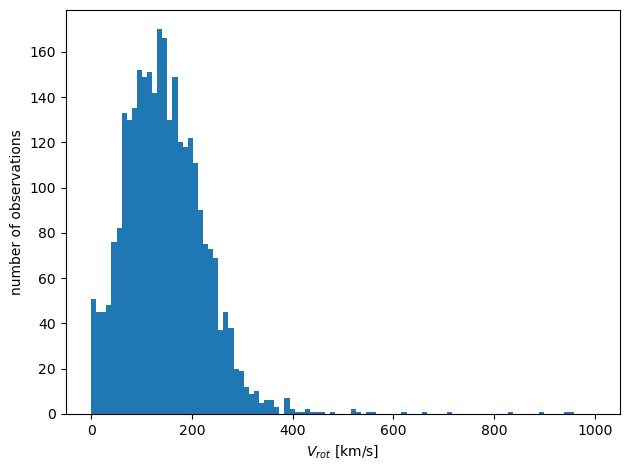

In [11]:
plt.figure(tight_layout=True)

plt.hist(np.abs(fuji_axis['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Cut for galaxies suitable for the TFR

Requirements:
 * $10 < V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $\Delta V / V_{min} \leq 5$
 
Note that I am *not* requiring a minimum inclination.  When targeted, we required some minimum in $i$; the tighter restriction that was used during calibration was to ensure a more robust calibration of the TFR.

I am also *not* requiring a morphological classification.  Again, we implemented this additional requirement for the calibration to make sure that the calibration was more robust.

And, I am not visually inspecting all of these objects.

## Velocity cut

In [12]:
r0p3 = (fuji_axis['SKY_FIBER_DIST_R26'] > 0.3) & (fuji_axis['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = (np.abs(fuji_axis['V_ROT']) < 1000) & (np.abs(fuji_axis['V_ROT']) > 10)

good_axis = fuji_axis[r0p3 & Vgood]

print(len(good_axis), len(np.unique(good_axis['SGA_ID'])))

2334 1205


## Relative velocity cut

In [13]:
good_deltaV = np.ones(len(good_axis), dtype=bool)

for sga_id in np.unique(good_axis['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            '''
            print(sga_id)
            print(diff_matrix_norm)
            print(1/v_norm_min.data)
            print(v_norm_max.data)
            print(good_axis[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
            ''';
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis['DELTACHI2'] >= 25
            
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    '''
                    print(sga_id)
                    print(diff_matrix_norm)
                    print(good_axis[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
                    ''';
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False

In [14]:
good_deltaV_axis = good_axis[good_deltaV]

print(len(good_deltaV_axis), len(np.unique(good_deltaV_axis['SGA_ID'])))

2307 1196


# TFR

## Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$:

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

In [15]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_err'] = np.nan

weights = 1./(good_deltaV_axis['V_ROT_ERR']**2)

for sga_id in np.unique(good_deltaV_axis['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_deltaV_axis['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(good_deltaV_axis['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    SGA['V_0p33R26_err'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))

In [16]:
# Make a catalog of just those galaxies with velocities
SGA_TF = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

print(len(SGA_TF))

1164


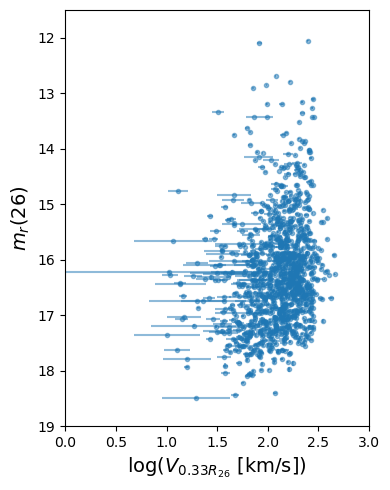

In [17]:
plt.figure(figsize=(4,5), tight_layout=True)

plt.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_MAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR'], 
             fmt='.', 
             alpha=0.5)

plt.xlim([0, 3])
plt.ylim([19, 11.5])

plt.xlabel('log($V_{0.33R_{26}}$ [km/s])', fontsize=14)
plt.ylabel('$m_r (26)$', fontsize=14);

## Compute the absolute magnitudes based on the redshift

In [18]:
d = c*SGA_TF['Z_DESI']/H0*1e6 # pc
d_err = c*SGA_TF['ZERR_DESI']/H0*1e6 # pc

SGA_TF['R_ABSMAG_SB26'] = SGA_TF['R_MAG_SB26'] - 5*np.log10(d/10.)
SGA_TF['R_ABSMAG_SB26_err'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + (5/np.log(10))**2 * (d_err/d)**2)

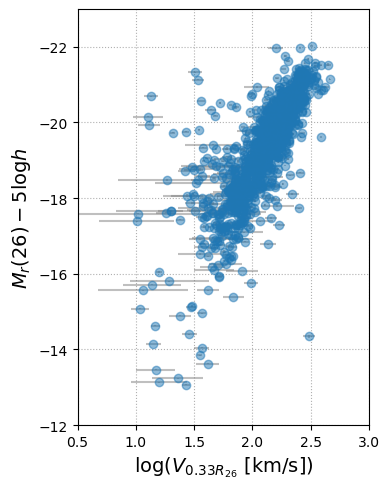

In [19]:
plt.figure(figsize=(4,5), tight_layout=True)

plt.grid(ls=':')

plt.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_ABSMAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_ABSMAG_SB26_err'], 
             fmt='o', 
             alpha=0.5, 
             ecolor='gray')

plt.xlim([0.5, 3])
plt.ylim([-12, -23])

plt.xlabel('log($V_{0.33R_{26}}$ [km/s])', fontsize=14)
plt.ylabel('$M_r (26) - 5$log$h$', fontsize=14);

## Plotted with our TFR

Here, the slope is from `Coma-Fuji-ITFR_KAD.ipynb` and the 0-pt is from the EDD calibration (`fuji_zero-point_ITFR_KAD.ipynb`):

\begin{equation}
  M_r = a (\log(V(0.33R_{26})) - V_0) + b
\end{equation}

where
* $a = -7.46^{+1.07}_{-1.65} = -7.46 \pm 1.58$
* $b = -22.27 \pm 0.24$

*(Updated 8/15/23)*

In [20]:
slope = -7.46
slope_err = 1.58

ZP = -22.27
ZP_err = 0.24

logv = np.linspace(-1, 3, 100)
absmag = slope*(logv - V0) + ZP

In [21]:
# Calculate the uncertainties in the calibrated TFR

N_samples = 10000

temp_infile = open('cov_ab_fuji_zero-point_ITFR_KAD.pickle', 'rb')
cov_ab = pickle.load(temp_infile)
temp_infile.close()

rng = np.random.default_rng()

# slopes = np.linspace(slope - slope_err, slope + slope_err, N_samples)
# ZPs = np.linspace(ZP - ZP_err, ZP + ZP_err, N_samples)
slopes, ZPs = rng.multivariate_normal([slope, ZP], cov_ab, N_samples).T

lines = []

for i in range(N_samples):
    lines.append(slopes[i]*(logv - V0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)

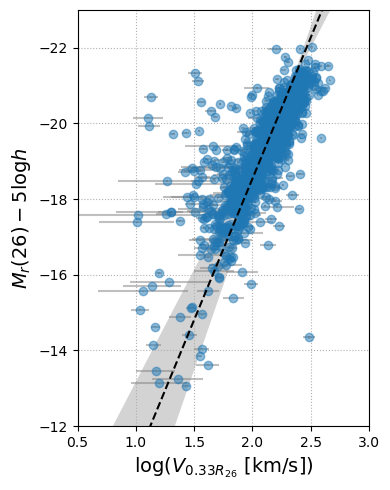

In [39]:
plt.figure(figsize=(4,5), tight_layout=True)

plt.grid(ls=':')

plt.fill_between(logv, line_err[0], line_err[1], color='lightgray')

plt.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_ABSMAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_ABSMAG_SB26_err'], 
             fmt='o', 
             alpha=0.5, 
             ecolor='gray')

# plt.errorbar(np.log10(SGA_TF['V_0p33R26'][dwarf_boolean]), 
#              SGA_TF['R_ABSMAG_SB26'][dwarf_boolean], 
#              xerr=0.434*SGA_TF['V_0p33R26_err'][dwarf_boolean]/SGA_TF['V_0p33R26'][dwarf_boolean],
#              yerr=SGA_TF['R_ABSMAG_SB26_err'][dwarf_boolean], 
#              fmt='g.', 
#              alpha=0.5, 
#              ecolor='gray')

plt.plot(logv, absmag, 'k--', zorder=3)

plt.xlim([0.5, 3])
plt.ylim([-12, -23])

plt.xlabel('log($V_{0.33R_{26}}$ [km/s])', fontsize=14)
plt.ylabel('$M_r (26) - 5$log$h$', fontsize=14);

plt.savefig('../../Figures/SV/fuji_TFR_all_20230817.png', dpi=150);

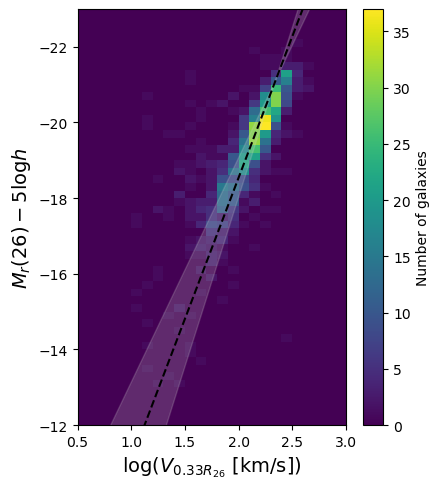

In [23]:
plt.figure(figsize=(4.5,5), tight_layout=True)

plt.hist2d(np.log10(SGA_TF['V_0p33R26']), 
           SGA_TF['R_ABSMAG_SB26'], 
           bins=[np.arange(0.5,3.1,0.1), np.arange(-23, -11.9, 0.2)])
plt.colorbar(label='Number of galaxies')

plt.fill_between(logv, line_err[0], line_err[1], color='lightgray', alpha=0.2)
plt.plot(logv, absmag, 'k--', zorder=3)

plt.xlim([0.5, 3])
plt.ylim([-12, -23])

plt.xlabel('log($V_{0.33R_{26}}$ [km/s])', fontsize=14)
plt.ylabel('$M_r (26) - 5$log$h$', fontsize=14);

## Plotted with our TFR calibrated without dwarfs

Here, the slope is from `Coma-Fuji-ITFR-nodwarfs_KAD.ipynb` and the 0-pt is from the EDD calibration (`fuji_zero-point_ITFR_nodwarf_KAD.ipynb`):

\begin{equation}
  M_r = a (\log(V(0.33R_{26})) - V_0) + b
\end{equation}

where
* $a = -7.57^{+1.19}_{-1.61} = -7.57\pm 1.61$
* $b = -22.29 \pm 0.27$

*(Updated 8/15/23)*

In [24]:
bright_slope = -7.57
bright_slope_err = 1.61

bright_ZP = -22.29
bright_ZP_err = 0.27

#logv = np.linspace(-1, 3, 100)
bright_absmag = bright_slope*(logv - V0) + bright_ZP

In [25]:
# Calculate the uncertainties in the calibrated TFR

temp_infile = open('cov_ab_fuji_zero-point_ITFR_nodwarf1_KAD.pickle', 'rb')
bright_cov_ab = pickle.load(temp_infile)
temp_infile.close()

# bright_slopes = np.linspace(bright_slope - bright_slope_err, bright_slope + bright_slope_err, N_samples)
# bright_ZPs = np.linspace(bright_ZP - bright_ZP_err, bright_ZP + bright_ZP_err, N_samples)
bright_slopes, bright_ZPs = rng.multivariate_normal([bright_slope, bright_ZP], bright_cov_ab, N_samples).T

bright_lines = []

for i in range(N_samples):
    bright_lines.append(bright_slopes[i]*(logv - V0) + bright_ZPs[i])
    
bright_lines_array = np.asarray(bright_lines)
bright_line_err = np.nanpercentile(bright_lines_array, [16 ,84], axis=0)

In [26]:
dwarf_boolean = np.log10(SGA_TF['V_0p33R26'] + SGA_TF['V_0p33R26_err']) < V0 - (17 + bright_ZP)/bright_slope

print(10**(V0 - (17 + bright_ZP)/bright_slope), 'km/s')

63.26869892025301 km/s


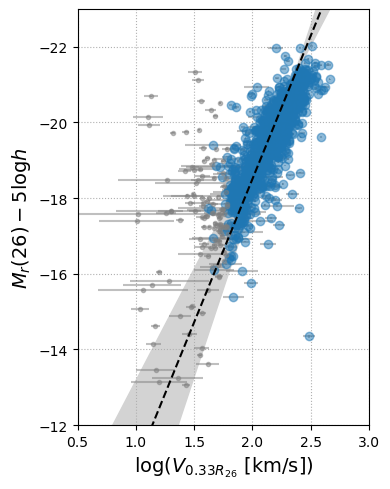

In [27]:
plt.figure(figsize=(4,5), tight_layout=True)

plt.grid(ls=':')

plt.fill_between(logv, bright_line_err[0], bright_line_err[1], color='lightgray')

plt.errorbar(np.log10(SGA_TF['V_0p33R26'][~dwarf_boolean]), 
             SGA_TF['R_ABSMAG_SB26'][~dwarf_boolean], 
             xerr=0.434*SGA_TF['V_0p33R26_err'][~dwarf_boolean]/SGA_TF['V_0p33R26'][~dwarf_boolean],
             yerr=SGA_TF['R_ABSMAG_SB26_err'][~dwarf_boolean], 
             fmt='o', 
             alpha=0.5, 
             ecolor='gray')
plt.errorbar(np.log10(SGA_TF['V_0p33R26'][dwarf_boolean]), 
             SGA_TF['R_ABSMAG_SB26'][dwarf_boolean], 
             xerr=0.434*SGA_TF['V_0p33R26_err'][dwarf_boolean]/SGA_TF['V_0p33R26'][dwarf_boolean],
             yerr=SGA_TF['R_ABSMAG_SB26_err'][dwarf_boolean], 
             fmt='.',
             color='gray',
             alpha=0.5, 
             ecolor='gray')

plt.plot(logv, bright_absmag, 'k--', zorder=3)

plt.xlim([0.5, 3])
plt.ylim([-12, -23])

plt.xlabel('log($V_{0.33R_{26}}$ [km/s])', fontsize=14)
plt.ylabel('$M_r (26) - 5$log$h$', fontsize=14);

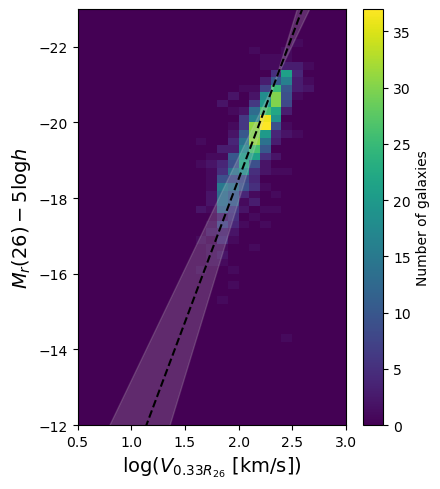

In [28]:
plt.figure(figsize=(4.5,5), tight_layout=True)

plt.hist2d(np.log10(SGA_TF['V_0p33R26'][~dwarf_boolean]), 
           SGA_TF['R_ABSMAG_SB26'][~dwarf_boolean], 
           bins=[np.arange(0.5,3.1,0.1), np.arange(-23, -11.9, 0.2)])
plt.colorbar(label='Number of galaxies')

plt.fill_between(logv, bright_line_err[0], bright_line_err[1], color='lightgray', alpha=0.2)
plt.plot(logv, bright_absmag, 'k--', zorder=3)

plt.xlim([0.5, 3])
plt.ylim([-12, -23])

plt.xlabel('log($V_{0.33R_{26}}$ [km/s])', fontsize=14)
plt.ylabel('$M_r (26) - 5$log$h$', fontsize=14);

-0.66674 -0.14654
-4.549883990719257 -6.824075337791729


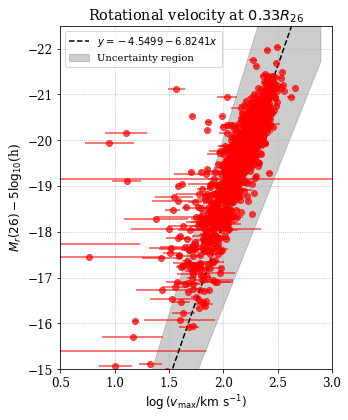

In [14]:
fig, ax = plt.subplots(1,1, figsize=(5,6), tight_layout=True)

# rmag_clean = np.asarray(rmag_clean)
# abs_mag_clean = np.asarray(abs_mag_clean)
# vmax_clean = np.asarray(vmax_clean)
# dvmax_clean = np.asarray(dvmax_clean)

# isrmeas_clean = rmag_clean > 0

# log10vmax_clean = np.log10(vmax_clean)
# dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean 

ax.errorbar(sga_tf['LOG_VMAX'],
            sga_tf['ABS_MAG_CALC'], 
            # yerr = sga_tf['ABS_MAG_CALC_ERR'],
            xerr = sga_tf['LOG_VMAX_ERR'], 
            fmt='ro', 
            alpha=0.7)


print(a, b)
print(_a, _b)

# ################################################################################


ax.set(ylabel='$M_r(26)-5\log_{10}$(h)',
       ylim=(-15, -22.5),
       xlabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       xlim=(0.5,3),
       title=r'Rotational velocity at $0.33R_{26}$')
ax.grid(ls=':')
# r = np.arange(-22.5, -15, 0.1)
logv = np.arange(-0.5, 3, 0.1)
ax.plot(logv, _a + _b*logv, 'k--', label='$y={:9.4f}{:6.4f}x$'.format(_a,_b))

slopes = np.linspace(_b-_db, _b+_db,20) 
intercepts = np.linspace(_a-_da, _a+_da, 20) 
line_array = []
for i in range(len(slopes)):
    line_array.append(logv*slopes[i] + intercepts[i])
line_array = np.asarray(line_array)
lower_edge = np.min(line_array,axis=0)
upper_edge = np.max(line_array,axis=0)
ax.fill_between(logv,lower_edge,upper_edge,color='gray',alpha=0.4, label = 'Uncertainty region')

ax.legend(loc='upper left', fontsize=10);

# fig.suptitle(r'Max velocity at $0.33\times R_{26}$', y=1.05)
# fig.subplots_adjust(top=0.8)
fig.savefig('tf_SGA_targets_04_15_2022_with_label.png', dpi=120, transparent=True)

# print(np.sum(isrmeas))

# Compute Peculiar Velocities

## Compute absolute magnitudes from TFR

Here, the slope is from `Coma-Fuji-ITFR_KAD.ipynb` and the 0-pt is from the EDD calibration (`fuji_zero-point_ITFR_KAD.ipynb`):

\begin{equation}
  M_r = a (\log(V(0.33R_{26})) - V_0) + b
\end{equation}

where
* $a = -7.46^{+1.07}_{-1.65}$
* $b = -22.27 \pm 0.24$

*(Updated 8/17/23)*

In [29]:
SGA_TF['R_ABSMAG_SB26_TF'] = slope*(np.log10(SGA_TF['V_0p33R26']) - V0) + ZP

In [30]:
SGA_TF['R_ABSMAG_SB26_TF_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = slopes*(np.log10(v_random) - V0) + ZPs
    
    SGA_TF['R_ABSMAG_SB26_TF_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_1787616/2679320965.py:7: RuntimeWarning: invalid value encountered in log10
  Ms = slopes*(np.log10(v_random) - V0) + ZPs


## Compute distance modulus based on our ITFR

In [31]:
SGA_TF['mu_TF'] = SGA_TF['R_MAG_SB26'] - SGA_TF['R_ABSMAG_SB26_TF']

SGA_TF['mu_TF_err'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + SGA_TF['R_ABSMAG_SB26_TF_err']**2)

## Compute absolute magnitudes from ITFR

Here, the slope is from `Coma-Fuji-ITFR-nodwarfs_KAD.ipynb` and the 0-pt is from the EDD calibration (`fuji_zero-point_ITFR_nodwarf_KAD.ipynb`):

\begin{equation}
  M_r = a (\log(V(0.33R_{26})) - V_0) + b
\end{equation}

where
* $a = -7.57^{+1.19}_{-1.61}$
* $b = -22.29 \pm 0.27$

*(Updated 8/17/23)*

In [32]:
SGA_TF['R_ABSMAG_SB26_TFbright'] = bright_slope*(np.log10(SGA_TF['V_0p33R26']) - V0) + bright_ZP

In [33]:
SGA_TF['R_ABSMAG_SB26_TFbright_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = bright_slopes*(np.log10(v_random) - V0) + bright_ZPs
    
    SGA_TF['R_ABSMAG_SB26_TFbright_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_1787616/38382638.py:7: RuntimeWarning: invalid value encountered in log10
  Ms = bright_slopes*(np.log10(v_random) - V0) + bright_ZPs


## Compute distance modulus based on our ITFR

In [34]:
SGA_TF['mu_TFbright'] = SGA_TF['R_MAG_SB26'] - SGA_TF['R_ABSMAG_SB26_TFbright']

SGA_TF['mu_TFbright_err'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + SGA_TF['R_ABSMAG_SB26_TFbright_err']**2)

### Save distance moduli to a fits file

In [37]:
hdr = fits.Header()

hdr['DESI_DR'] = 'EDR'
hdr['V_RADIUS'] = '0.33 R26'
hdr['M'] = slope
hdr['M_ERR'] = slope_err
hdr['0PT'] = ZP
hdr['0PT_ERR'] = ZP_err
hdr['M_BR'] = bright_slope
hdr['M_ERR_BR'] = bright_slope_err
hdr['V0'] = V0

empty_primary = fits.PrimaryHDU(header=hdr)

In [38]:
table_hdu = fits.BinTableHDU(data=SGA_TF)

hdul = fits.HDUList([empty_primary, table_hdu])

# Write results to file
#SGA_TF.write('SGA_fuji_TFR_moduli.fits', overwrite=True)
hdul.writeto('SGA_fuji_ITFR_moduli.fits', overwrite=True)

In [27]:
## Extract observed redshift and compute peculiar redshift
z_obs = []
dz_obs = []
z_H = []
dz_H = []
z_p = []
dz_p = []
bad_id = []

for i in range(len(sga_tf['SGA_ID'])):
    
    sga_id = sga_tf['SGA_ID'][i]
    M_obs, dM_obs = sga_tf['ABS_MAG_CALC'][i], sga_tf['ABS_MAG_CALC_ERR'][i] 
    M_TF, dM_TF = abs_mag_tf[i], abs_mag_tf_err[i] 
    
    galaxy_list = sga_table[sga_table['SGA_ID'] == sga_id]
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    zc, zc_err = float(sga_galaxy['Z']), float(sga_galaxy['ZERR'])
    z_obs.append(zc)
    dz_obs.append(zc_err)
    # print(zc)
    if np.shape(sga_galaxy['R_MAG_SB26']) == (0,):
        bad_id.append(sga_id)
        continue
    m, m_err = float(sga_galaxy['R_MAG_SB26']), float(sga_galaxy['R_MAG_SB26_ERR'])
    zH = zc * 10**((M_obs-M_TF)/5)
    dzH = np.sqrt(zc_err**2 * 10**(2*(M_obs-M_TF)/5) + (zc*np.log(10)/5)**2 * (dM_obs**2 * 10**(2*M_obs/5)+dM_TF**2 * 10**(2*M_TF/5)))
    z_H.append(zH)
    dz_H.append(dzH)
    z_p.append(((1+zc)/(1+zH)) - 1)
    dz_p.append(np.sqrt(((1+zc)/(1+zH)**2 * dzH)**2 + (zc_err/(1+zH))**2))

In [28]:
sga_tf['Z_OBS'] = z_obs
sga_tf['Z_OBS_ERR'] = dz_obs
sga_tf['Z_H'] = z_H
sga_tf['Z_H_ERR'] = dz_H
sga_tf['Z_P'] = z_p
sga_tf['Z_P_ERR'] = dz_p

In [30]:
sga_tf['ABS_MAG_TF'] = abs_mag_tf
sga_tf['ABS_MAG_TF_ERR'] = abs_mag_tf_err

In [31]:
sga_tf.write('cache/SGA_PV.fits', format = 'fits', overwrite = True)

In [12]:
sga_tf = Table.read('cache/SGA_PV.fits', format = 'fits')
sga_tf.columns

<TableColumns names=('SGA_ID','PGC','RMAG','RMAG_ERR','VMAX','VMAX_ERR','LOG_VMAX','LOG_VMAX_ERR','ABS_MAG_CALC','ABS_MAG_CALC_ERR','Z_OBS','Z_OBS_ERR','Z_H','Z_H_ERR','Z_P','Z_P_ERR','ABS_MAG_TF','ABS_MAG_TF_ERR')>

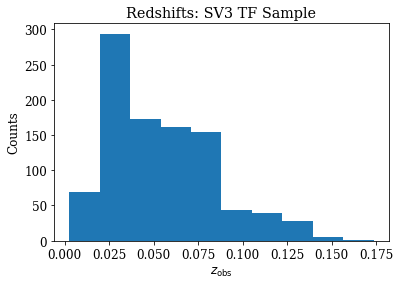

In [20]:
plt.hist(sga_tf['Z_OBS'])
plt.xlabel(r'$z_\mathrm{obs}$')
plt.ylabel('Counts')
plt.title('Redshifts: SV3 TF Sample')
# plt.axvline(0.05, color = 'k', ls = ':')
# plt.show()
plt.savefig('z_obs_hist_SV3.png', dpi=120, transparent=True)